In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-01 09:17:12 __main__ INFO     torch.__version__='2.8.0+cu128', torch.version.cuda='12.8'
2025-09-01 09:17:12 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-01 09:17:12 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-01 09:17:15 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-01 09:17:15 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key= "/disk/u/gio/mechinterp/models/" + model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-01 09:18:04 src.models INFO     loaded model </disk/u/gio/mechinterp/models/meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [ ]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [5]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task_obj = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

In [6]:
sample = select_task_obj.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="jewelry",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Pin -> Brooch (2): ['Monkey', 'Soap', 'Brooch', 'Flute', 'Air fryer', 'Carnation']
Options: Monkey, Soap, Brooch, Flute, Air fryer, Carnation.
Which among these objects mentioned above is a jewelry?
Answer:


In [7]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Monkey, Soap, Brooch, Flute, Air fryer, Carnation.
Which among these objects mentioned above is a jewelry?
Answer:" >> Brooch


(True,
 [PredictedToken(token=' Bro', prob=0.6953125, logit=21.75, token_id=6031, metadata=None),
  PredictedToken(token=' The', prob=0.09423828125, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.09423828125, logit=19.75, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.06494140625, logit=19.375, token_id=22395, metadata=None),
  PredictedToken(token=' It', prob=0.01123046875, logit=17.625, token_id=1102, metadata=None)],
 OrderedDict([(6031,
               (1,
                PredictedToken(token=' Bro', prob=0.6953125, logit=21.75, token_id=6031, metadata=None))),
              (3061,
               (13,
                PredictedToken(token=' Fl', prob=0.0011138916015625, logit=15.3125, token_id=3061, metadata=None))),
              (61731,
               (25,
                PredictedToken(token=' Soap', prob=0.00049591064453125, logit=14.5, token_id=61731, metadata=None))),
              (32749,
               (35,
              

In [38]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Earring. An earring is a piece of jewelry attached to the ear via a piercing in the" >> Earring


In [9]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


2025-09-01 09:18:26 matplotlib DEBUG    matplotlib data path: /disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-01 09:18:26 matplotlib DEBUG    CONFIGDIR=/disk/u/gio/.config/matplotlib
2025-09-01 09:18:26 matplotlib DEBUG    interactive is False
2025-09-01 09:18:26 matplotlib DEBUG    platform is linux
2025-09-01 09:18:27 matplotlib DEBUG    CACHEDIR=/disk/u/gio/.cache/matplotlib
2025-09-01 09:18:27 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/gio/.cache/matplotlib/fontlist-v390.json
2025-09-01 09:18:27 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-01 09:18:27 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-01 09:18:27 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-01 09:18:27 matplotlib.font_manager DEB

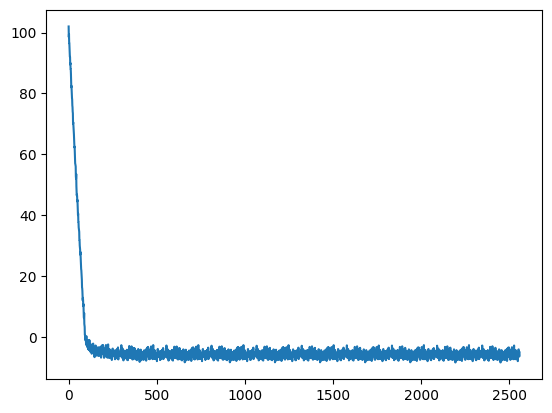

In [8]:
from matplotlib import pyplot as plt
import numpy as np

optimized_path = os.path.join(
    "/disk/u/arnab/Codes/Projects/retrieval/results",
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "distinct_options/select_one/epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

78


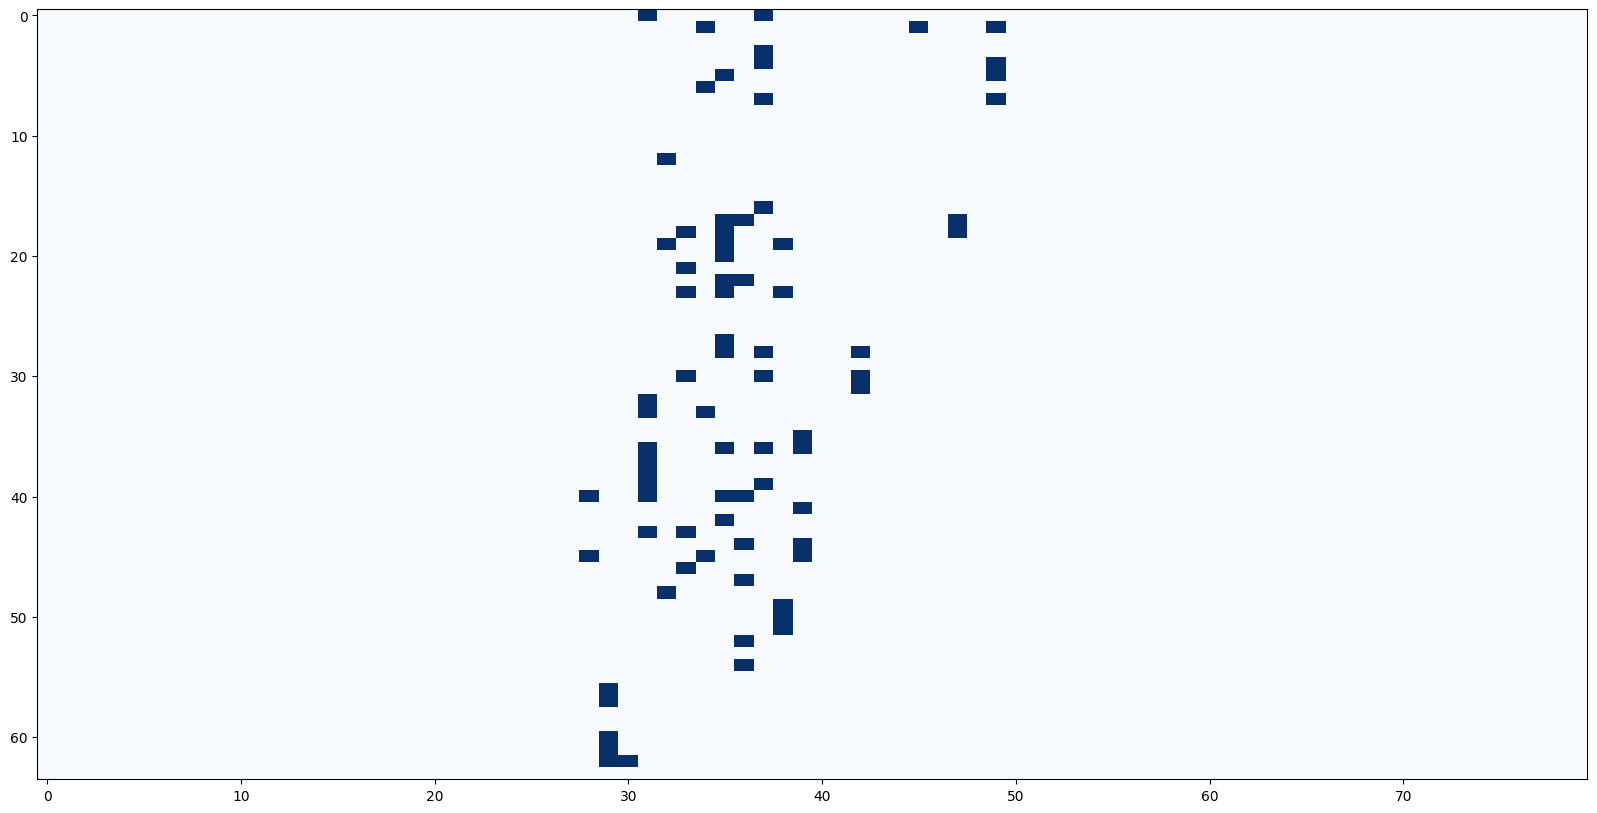

In [10]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

#(35, 19) in HEADS, (35, 19) in heads_selected

In [11]:
FILTER_HEADS = HEADS

In [15]:
FV_HEADS_RAW = [
    (33, 52, 0.0297),
    (37, 2, 0.0224),
    (34, 2, 0.0209),
    (34, 24, 0.0194),
    (66, 7, 0.0185),
    (34, 25, 0.0167),
    (76, 10, 0.0155),
    (69, 39, 0.0152),
    (31, 18, 0.0147),
    (76, 63, 0.0142),
    (34, 41, 0.0116),
    (38, 49, 0.0112),
    (49, 1, 0.0107),
    (32, 3, 0.0102),
    (36, 22, 0.0102),
    (22, 55, 0.0101),
    (34, 51, 0.01),
    (67, 30, 0.0098),
    (69, 41, 0.0097),
    (16, 37, 0.0097),
    (34, 52, 0.0096),
    (55, 20, 0.0094),
    (40, 39, 0.0093),
    (37, 29, 0.0091),
    (76, 57, 0.009),
    (38, 23, 0.0087),
    (33, 31, 0.0087),
    (77, 42, 0.0087),
    (35, 57, 0.0084),
    (44, 7, 0.0081),
    (34, 31, 0.0076),
    (18, 7, 0.0075),
    (38, 55, 0.0073),
    (55, 17, 0.0069),
    (79, 1, 0.0068),
    (33, 3, 0.0067),
    (54, 8, 0.0067),
    (35, 47, 0.0066),
    (74, 9, 0.0065),
    (45, 6, 0.0064),
    (48, 56, 0.0063),
    (38, 48, 0.0061),
    (33, 11, 0.0061),
    (38, 28, 0.006),
    (39, 44, 0.0059),
    (38, 62, 0.0058),
    (21, 34, 0.0057),
    (33, 9, 0.0057),
    (75, 28, 0.0057),
    (70, 40, 0.0053),
    (35, 21, 0.0051),
    (34, 5, 0.0051),
    (44, 1, 0.0049),
    (77, 43, 0.0047),
    (34, 54, 0.0047),
    (38, 61, 0.0046),
    (39, 41, 0.0046),
    (38, 18, 0.0046),
    (14, 61, 0.0045),
    (77, 21, 0.0044),
    (73, 15, 0.0044),
    (33, 32, 0.0043),
    (72, 40, 0.004),
    (35, 16, 0.004),
    (36, 3, 0.0039),
    (78, 51, 0.0037),
    (31, 7, 0.0036),
    (17, 14, 0.0035),
    (47, 18, 0.0034),
    (20, 53, 0.0034),
    (49, 4, 0.0033),
    (63, 59, 0.0033),
    (33, 42, 0.0033),
    (32, 22, 0.0033),
    (36, 4, 0.0033),
    (24, 7, 0.0033),
    (27, 22, 0.0032),
    (75, 1, 0.0032),
    (73, 61, 0.0031),
    (35, 44, 0.0031),
    (49, 6, 0.003),
    (30, 24, 0.003),
    (41, 22, 0.003),
    (31, 17, 0.003),
    (60, 28, 0.003),
    (79, 11, 0.003),
    (34, 40, 0.003),
    (31, 6, 0.0029),
    (73, 14, 0.0028),
    (73, 7, 0.0028),
    (32, 5, 0.0028),
    (75, 54, 0.0028),
    (77, 6, 0.0028),
    (35, 45, 0.0027),
    (31, 55, 0.0027),
    (26, 31, 0.0027),
    (34, 47, 0.0027),
    (79, 32, 0.0027),
    (74, 13, 0.0027),
    (33, 48, 0.0026),
]

FV_HEADS = [(l, h) for l, h, s in FV_HEADS_RAW[:78]]

FV_HEADS

[(33, 52),
 (37, 2),
 (34, 2),
 (34, 24),
 (66, 7),
 (34, 25),
 (76, 10),
 (69, 39),
 (31, 18),
 (76, 63),
 (34, 41),
 (38, 49),
 (49, 1),
 (32, 3),
 (36, 22),
 (22, 55),
 (34, 51),
 (67, 30),
 (69, 41),
 (16, 37),
 (34, 52),
 (55, 20),
 (40, 39),
 (37, 29),
 (76, 57),
 (38, 23),
 (33, 31),
 (77, 42),
 (35, 57),
 (44, 7),
 (34, 31),
 (18, 7),
 (38, 55),
 (55, 17),
 (79, 1),
 (33, 3),
 (54, 8),
 (35, 47),
 (74, 9),
 (45, 6),
 (48, 56),
 (38, 48),
 (33, 11),
 (38, 28),
 (39, 44),
 (38, 62),
 (21, 34),
 (33, 9),
 (75, 28),
 (70, 40),
 (35, 21),
 (34, 5),
 (44, 1),
 (77, 43),
 (34, 54),
 (38, 61),
 (39, 41),
 (38, 18),
 (14, 61),
 (77, 21),
 (73, 15),
 (33, 32),
 (72, 40),
 (35, 16),
 (36, 3),
 (78, 51),
 (31, 7),
 (17, 14),
 (47, 18),
 (20, 53),
 (49, 4),
 (63, 59),
 (33, 42),
 (32, 22),
 (36, 4),
 (24, 7),
 (27, 22),
 (75, 1)]

In [16]:
filter_heads_set = set(FILTER_HEADS)
fv_heads_set = set(FV_HEADS)

intersection = filter_heads_set & fv_heads_set
intersection


{(36, 22), (38, 23), (38, 49), (39, 41), (39, 44), (47, 18), (49, 1), (49, 4)}

In [18]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="numbered"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=FILTER_HEADS,
)

0 patches to ablate possible answer information from options
2025-09-01 09:20:00 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.703, logit=21.875)', '" ("[320] (p=0.095, logit=19.875)', '" The"[578] (p=0.065, logit=19.500)', '" A"[362] (p=0.058, logit=19.375)', '" Bro"[6031] (p=0.027, logit=18.625)']
2025-09-01 09:20:00 src.selection.functional INFO     Combined attention matrix for all heads


In [15]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    clean_option_style="numbered",
    patch_option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        prompt_template = task.prompt_templates[prompt_template_idx],
        default_option_style=patch_option_style,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        prompt_template = task.prompt_templates[prompt_template_idx],
        default_option_style=clean_option_style,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [23]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    distinct_options=True,
    n_distractors = N_DISTRACTORS,
)

clean_sample.metadata

2025-08-18 14:14:14 __main__ INFO     Patch category: fruit, subject: Banana, object: Pineapple
2025-08-18 14:14:14 __main__ INFO     Clean category: vehicle, subject: Submarine, object: Scooter
2025-08-18 14:14:14 __main__ INFO     patch_must_have_options=['Pineapple', 'Motorcycle']
2025-08-18 14:14:14 __main__ INFO     clean_must_have_options=['Scooter', 'Raspberry']
2025-08-18 14:14:14 __main__ INFO     clean_type_obj='Motorcycle'
2025-08-18 14:14:14 __main__ INFO     patch_type_obj='Raspberry'


2025-08-18 14:14:14 __main__ INFO     patch_obj_idx=0 | ['Pineapple', 'Motorcycle', 'Pepper', 'Binder', 'Dog', 'Refrigerator']
2025-08-18 14:14:14 __main__ INFO     clean_obj_idx=2 | ['Anklet', 'Harmonica', 'Scooter', 'Refrigerator', 'Pepper', 'Raspberry']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-18 14:14:14 __main__ INFO     Options: Pineapple, Motorcycle, Pepper, Binder, Dog, Refrigerator.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-18 14:14:14 __main__ INFO     Banana | fruit -> Pineapple | pred=['" Pine"[42609] (p=0.770, logit=21.375)', '" The"[578] (p=0.104, logit=19.375)', '" Among"[22395] (p=0.056, logit=18.750)', '" A"[362] (p=0.034, logit=18.250)', '" It"[1102] (p=0.005, logit=16.250)']
2025-08-18 14:14:14 __main__ INFO     a. Anklet
b. Harmonica
c. Scooter
d. Refrigerator
e. Pepper
f. Raspberry
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-18 14:14:14 __main__ INFO     Submarine | vehicle -> Scooter | pr

{'track_category': 'fruit',
 'track_type_obj': 'Raspberry',
 'track_type_obj_idx': 5,
 'track_type_obj_token_id': 48665,
 'tokenized': {'input_ids': tensor([[128000,     64,     13,  57915,   1169,    198,     65,     13,  40759,
             3074,    198,     66,     13,  50159,  26464,    198,     67,     13,
            75258,    859,    198,     68,     13,  52882,    198,     69,     13,
            48665,    198,  23956,   4315,   1521,   6302,   9932,   3485,    374,
              264,   7458,   5380,  16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}}

In [46]:
tok_id = get_first_token_id("1", mt.tokenizer, prefix="")
mt.tokenizer.decode(tok_id)

'1'

In [157]:
patch_sample = SelectionSample(
    subj="#",
    obj="43",
    options=["43", "57", "55", "62", "39"],
    prompt_template="Which of the following numbers is a multiple of 3?\n<_options_>\nAnswer:",
    obj_idx=0,
    answer="Yes",
)

clean_sample_2 = SelectionSample(
    subj="#",
    obj="Michael Jordan",
    options=[
        "Michael Jordan",
        "Serena Williams",
        "Justin Trudeau",
        "Mike Tyson",
        "Carl Sagan",
        "Tom Cruise",
    ],
    prompt_template="Who among these people shares the same profession as Roger Federer?\n<_options_>\nAnswer:",
    obj_idx=0,
    answer="Yes",
)


clean_sample = SelectionSample(
    subj="#",
    obj="Bus",
    options=["Bus", "Peach", "Watch", "Car", "Banana", "Rabbit", "Mango"],
    prompt_template="<_options_>\nCount the number of fruits in the list above.\nAnswer: ",
    obj_idx=0,
    answer="2",
    ans_token_id=get_first_token_id("2", mt.tokenizer, prefix=""),
)

clean_sample.metadata = {
    "track_type_obj": "1",
    "track_type_obj_token_id": get_first_token_id("1", mt.tokenizer, prefix=""),
}

In [ ]:
from src.functional import generate_with_patch

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
patch_sample.default_option_style = "single_line"
clean_sample.default_option_style = "numbered"

for sample in [clean_sample_2, patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Who among these people shares the same profession as Roger Federer?
Options: Michael Jordan, Serena Williams, Justin Trudeau, Mike Tyson, Carl Sagan, Tom Cruise.
Answer: >> Michael Jordan
0 patches to ablate possible answer information from options
2025-08-19 10:57:30 src.selection.functional DEBUG    Generated full answer: " Serena Williams. Both Roger Federer and Serena Williams are professional tennis players. The rest of the people mentioned are either athletes in different sports, politicians,"
2025-08-19 10:57:31 src.selection.functional DEBUG    Predictions: ['" Serena"[92090] (p=0.887, logit=21.375)', '" The"[578] (p=0.044, logit=18.375)', '" Among"[22395] (p=0.013, logit=17.125)', '" Only"[8442] (p=0.010, logit=16.875)', '" Roger"[29607] (p=0.008, logit=16.625)']
2025-08-19 10:57:31 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Which of the following numbers is a multiple of 3?
Options: 43, 57, 55, 62, 39.
Answer: >> 43
0 patches to ablate possible answer information from options
2025-08-19 10:57:58 src.selection.functional DEBUG    Generated full answer: " 57 and 39 are multiples of 3.
Explanation: A number is a multiple of 3 if the sum of its digits is a multiple"
2025-08-19 10:57:59 src.selection.functional DEBUG    Predictions: ['" "[220] (p=0.617, logit=19.625)', '" The"[578] (p=0.121, logit=18.000)', '" A"[362] (p=0.039, logit=16.875)', '" To"[2057] (p=0.031, logit=16.625)', '" We"[1226] (p=0.021, logit=16.250)']
2025-08-19 10:57:59 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


a. Bus
b. Peach
c. Watch
d. Car
e. Banana
f. Rabbit
g. Mango
Count the number of fruits in the list above.
Answer:  >> Bus
0 patches to ablate possible answer information from options
2025-08-19 10:58:27 src.selection.functional DEBUG    Generated full answer: "3
Explanation: The fruits in the list are Peach, Banana, and Mango. Therefore, the number of fruits in the list is 3."
2025-08-19 10:58:28 src.selection.functional DEBUG    Predictions: ['"3"[18] (p=0.926, logit=23.125)', '"4"[19] (p=0.052, logit=20.250)', '"2"[17] (p=0.008, logit=18.375)', '"1"[16] (p=0.003, logit=17.500)', '"5"[20] (p=0.003, logit=17.375)']
2025-08-19 10:58:28 src.selection.functional INFO     Combined attention matrix for all heads


: 

## Validation of the patching effect

In [133]:
# from src.functional import free_gpu_cache
# free_gpu_cache()
# validation_set = []
# validation_limit = 256

# while len(validation_set) < validation_limit:
#     patch, clean = get_counterfactual_samples_within_task(
#         filter_by_lm_prediction=True,
#         prompt_template_idx=prompt_template_idx,
#         distinct_options=True,
#         n_distractors=N_DISTRACTORS,
#     )
#     validation_set.append((clean, patch))

In [134]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair


# clean, patch = copy.deepcopy(validation_set[28])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]
clean, patch = clean_sample, patch_sample
# clean, patch = order_sample_2, order_sample_1
# patch, clean = order_sample_1, order_sample_2
# failed_case = failed_cases[0]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

# patch.options[patch.obj_idx] = "Mango"
# patch.options = ["#"]
print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads = heads_selected,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=1.5,
    must_track_tokens=[clean.metadata["track_type_obj_token_id"], clean.ans_token_id],
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = after_intervention["target_rank"] - before_intervention["target_rank"]
logger.info(f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} ")
logger.info(f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} ")

clean_logit_delta = after_intervention["clean_logit"] - before_intervention["clean_logit"]
target_logit_delta =  after_intervention["target_logit"] - before_intervention["target_logit"]
logger.info(f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} ")
logger.info(f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} ")

a. Bus
b. Mug
c. Car
d. Peach
Count the number of vehicles in the list
Answer: 1 >> Bus
Options: Bike, Banana, Watch.
Is there a fruit in the list?
Answer: >> Bike
2025-08-18 15:19:03 src.selection.optimization INFO     Verifying head behavior...
2025-08-18 15:19:03 src.selection.optimization INFO     Clean Sample >> Ans: Bus


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-18 15:19:06 src.selection.functional DEBUG    Generated full answer: "
Explanation: There is only one vehicle in the list, which is the bus. The other options are not vehicles. A mug is a type of"
2025-08-18 15:19:07 src.selection.functional DEBUG    Predictions: ['"\n"[198] (p=0.330, logit=16.500)', '"."[13] (p=0.101, logit=15.312)', '"\n\n"[271] (p=0.101, logit=15.312)', '" ("[320] (p=0.073, logit=15.000)', '" bus"[5951] (p=0.045, logit=14.500)']
2025-08-18 15:19:07 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-18 15:19:07 src.selection.optimization INFO     Patch Sample >> Ans: Bike


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-18 15:19:10 src.selection.functional DEBUG    Generated full answer: " Yes, there is a fruit in the list. The fruit is Banana. 
Explanation: The question requires the ability to identify a specific category (fruit"
2025-08-18 15:19:10 src.selection.functional DEBUG    Predictions: ['" Yes"[7566] (p=0.879, logit=21.500)', '" yes"[10035] (p=0.030, logit=18.125)', '" Banana"[76924] (p=0.026, logit=18.000)', '" YES"[14410] (p=0.018, logit=17.625)', '" No"[2360] (p=0.011, logit=17.125)']
2025-08-18 15:19:10 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-18 15:19:10 src.selection.optimization INFO     Caching the query states for the 66 heads
2025-08-18 15:19:11 src.selection.optimization INFO     patch_prediction=['" Yes"[7566] (p=0.879, logit=21.500)', '" yes"[10035] (p=0.030, logit=18.125)', '" Banana"[76924] (p=0.026, logit=18.000)', '" YES"[14410] (p=0.018, logit=17.625)', '" No"[2360] (p=0.011, logit=17.125)']
2025-08-18 15:19:11 src.selection.optimization INFO     clean run
2025-08-18 15:19:11 src.selection.optimization INFO     clean_prediction=['"\n"[198] (p=0.330, logit=16.500)', '"\n\n"[271] (p=0.101, logit=15.312)', '"."[13] (p=0.101, logit=15.312)', '" ("[320] (p=0.073, logit=15.000)', '" bus"[5951] (p=0.045, logit=14.500)']
2025-08-18 15:19:11 src.selection.optimization INFO     clean_track=OrderedDict([(19111, (16, PredictedToken(token=' Bus', prob=0.00775146484375, logit=12.75, token_id=19111, metadata=None))), (3341, (32, PredictedToken(token=' Car', prob=0.0023651123046875, logit=11.5625, token_id=3341, metada

2025-08-18 15:19:11 src.selection.optimization INFO     int_prediction=['"\n"[198] (p=0.570, logit=19.000)', '"\n\n"[271] (p=0.113, logit=17.375)', '" ("[320] (p=0.088, logit=17.125)', '"."[13] (p=0.060, logit=16.750)', '","[11] (p=0.032, logit=16.125)']
2025-08-18 15:19:11 src.selection.optimization INFO     int_track=OrderedDict([(64695, (12, PredictedToken(token=' Peach', prob=0.005615234375, logit=14.375, token_id=64695, metadata=None))), (19111, (52, PredictedToken(token=' Bus', prob=0.000263214111328125, logit=11.3125, token_id=19111, metadata=None))), (64574, (68, PredictedToken(token=' Mug', prob=0.00014972686767578125, logit=10.75, token_id=64574, metadata=None))), (3341, (114, PredictedToken(token=' Car', prob=6.246566772460938e-05, logit=9.875, token_id=3341, metadata=None))), (16, (18021, PredictedToken(token='1', prob=2.7706846594810486e-08, logit=2.15625, token_id=16, metadata=None))), (17, (18809, PredictedToken(token='2', prob=2.5960616767406464e-08, logit=2.09375, toke

In [135]:
from src.selection.functional import cache_q_projections
patch_tokenized = prepare_input(
    tokenizer=mt,
    prompts=patch_sample.prompt()
)
clean_tokenized = prepare_input(
    tokenizer=mt,
    prompts=clean_sample.prompt()
)

query_indices = {-3: -3, -2: -2, -1: -1}

query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in heads_selected
    for patch_query_idx in query_indices.keys()
]

cached_q_states, patch_output = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)

In [136]:
from src.functional import get_module_nnsight, interpret_logits

layer_to_hq = {}
for layer_idx, head_idx, query_idx in query_locations:
    if layer_idx not in layer_to_hq:
        layer_to_hq[layer_idx] = []
    layer_to_hq[layer_idx].append((head_idx, query_idx))

q_projections = {}
batch_size = clean_tokenized.input_ids.shape[0]
seq_len = clean_tokenized.input_ids.shape[1]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
with mt.trace(clean_tokenized) as tracer:
    for layer_idx, query_locs in layer_to_hq.items():
        q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        q_proj_module = get_module_nnsight(mt, q_proj_name)
        tracer.log(q_proj_module.output.shape)
        q_proj_out = q_proj_module.output.view(
            batch_size, seq_len, n_heads, head_dim
        ).transpose(1, 2)
        for head_idx, token_idx in query_locs:
            q_proj_out[:, head_idx, token_idx, :] = cached_q_states[(layer_idx, head_idx, token_idx)]
    
    output = mt.output.save()

logits = output.logits[:, -1, :].squeeze()
pred, track = interpret_logits(
    logits=logits,
    tokenizer=mt.tokenizer,
    interested_tokens=[
        clean.ans_token_id,
        clean.metadata["track_type_obj_token_id"],
    ],
)
pred, track

torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])
torch.Size([1, 30, 8192])


([PredictedToken(token='\n', prob=0.5703125, logit=19.0, token_id=198, metadata=None),
  PredictedToken(token='\n\n', prob=0.11279296875, logit=17.375, token_id=271, metadata=None),
  PredictedToken(token=' (', prob=0.087890625, logit=17.125, token_id=320, metadata=None),
  PredictedToken(token='.', prob=0.060302734375, logit=16.75, token_id=13, metadata=None),
  PredictedToken(token=',', prob=0.0322265625, logit=16.125, token_id=11, metadata=None)],
 OrderedDict([(16,
               (17930,
                PredictedToken(token='1', prob=2.7706846594810486e-08, logit=2.15625, token_id=16, metadata=None))),
              (17,
               (18808,
                PredictedToken(token='2', prob=2.5960616767406464e-08, logit=2.09375, token_id=17, metadata=None)))]))

In [137]:
with mt.generate(
    clean_tokenized,
    max_new_tokens=20,
    do_sample=False,
    output_scores=True,
    return_dict_in_generate=True,
    use_cache=False
) as tracer:
    mt.all()  # patch at all token positions
    for layer_idx, query_locs in layer_to_hq.items():
        q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        q_proj_module = get_module_nnsight(mt, q_proj_name)
        q_proj_out = q_proj_module.output.view(
            batch_size, -1, n_heads, head_dim
        ).transpose(1, 2)
        for head_idx, token_idx in query_locs:
            q_proj_out[:, head_idx, token_idx, :] = cached_q_states[
                (layer_idx, head_idx, token_idx)
            ]
    gen_out = mt.generator.output.save()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [138]:
start = clean_tokenized.input_ids.shape[1]
mt.tokenizer.batch_decode(
    gen_out.sequences[:, start:],
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)[0].strip()

'Explanation: There is only one vehicle in the list, which is "Peach" is not'

In [139]:
interpret_logits(
    mt.tokenizer,
    gen_out.scores[0],
    interested_tokens=[
        clean.ans_token_id,
        clean.metadata["track_type_obj_token_id"],
    ],
)

([PredictedToken(token='\n', prob=0.5726500749588013, logit=19.0, token_id=198, metadata=None),
  PredictedToken(token='\n\n', prob=0.1127614825963974, logit=17.375, token_id=271, metadata=None),
  PredictedToken(token=' (', prob=0.08781874179840088, logit=17.125, token_id=320, metadata=None),
  PredictedToken(token='.', prob=0.06035687401890755, logit=16.75, token_id=13, metadata=None),
  PredictedToken(token=',', prob=0.03230670839548111, logit=16.125, token_id=11, metadata=None)],
 OrderedDict([(16,
               (17914,
                PredictedToken(token='1', prob=2.7716708927982836e-08, logit=2.15625, token_id=16, metadata=None))),
              (17,
               (18796,
                PredictedToken(token='2', prob=2.6037438871640006e-08, logit=2.09375, token_id=17, metadata=None)))]))